# Using xgcm with POP output

In this notebook we will use xgcm capability to calculate divergence, vorticity and scalar gradients from high resolution (0.1$^{\circ}$) POP output.  We will

1) demonstrate the functions needed for these operations with basic `xarray`

2) translate them to the corresponding ```xgcm``` version using {py:meth}`~xgcm.Grid.diff` and {py:meth}`~xgcm.Grid.interp`.

3) use [`xgcm.get_metric`](https://xgcm.readthedocs.io/en/latest/grid_metrics.html) capabilities to simplify the code. 

The ``metrics`` functionality lets us write generalized ``div``, ``grad`` and ``curl`` functions that should be available in ``xgcm`` in the future (see [xgcm/xgcm #187](https://github.com/xgcm/xgcm/issues/187)). 


This notebook was contributed by [Anna-Lena Deppenmeier](https://github.com/ALDepp).

## Import packages

In [1]:
import numpy as np
import xarray as xr
import xgcm
from matplotlib import pyplot as plt

import pop_tools

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

## Open example dataset and modify it to work with xgcm
For the relabeling the dataset must contain ``DZU`` and ``DZT`` (they are also needed in calculations later on)

In [2]:
# open sample data
filepath = pop_tools.DATASETS.fetch('Pac_POP0.1_JRA_IAF_1993-12-6-test.nc')
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch('Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc')
ds_g = xr.open_dataset(filepath_g)

In [3]:
ds["DZT"] = ds_g.DZT
ds["DZU"] = ds_g.DZU
ds["cell_volume_t"] = ds_g.DZT * ds_g.DXT * ds_g.DYT
ds["cell_volume_u"] = ds_g.DZU * ds_g.DXT * ds_g.DYT

ds contains the usual dimensions ```nlat```, ```nlon```, etc:

In [4]:
ds

<xarray.Dataset>
Dimensions:         (nlat: 305, nlon: 1301, time: 1, z_t: 62, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time            (time) object 0036-12-07 00:00:00
  * z_t             (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot         (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG           (nlat, nlon) float64 ...
    ULAT            (nlat, nlon) float64 ...
    TLONG           (nlat, nlon) float64 ...
    TLAT            (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables: (12/30)
    TEND_TEMP       (time, z_t, nlat, nlon) float32 ...
    UET             (time, z_t, nlat, nlon) float32 ...
    VNT             (time, z_t, nlat, nlon) float32 ...
    WTT             (time, z_w_top, nlat, nlon) float32 ...
    KPP_SRC_TEMP    (time, z_t, nlat, nlon) float32 ...
    UVEL            (time, z_t, nlat, nlon) float32 ...
    ...              ...
    SHF             (time, nlat, nlon) float32 ...
    SHF_QSW         (time, nlat, nlon) float32 ...
    DZT             (z_t, nlat, nlon) float32 ...
    DZU             (z_t, nlat, nlon) float32 ...
    cell_volume_t   (z_t, nlat, nlon) float64 1.153e+15 1.153e+15 ... 2.884e+16
    cell_volume_u   (z_t, nlat, nlon) float64 1.153e+15 1.153e+15 ... 2.884e+16
Attributes:
    title:             g.e20.G.TL319_t13.control.001_hfreq
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-12-14 at 16:05:58.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

We call {py:func}`~pop_tools.to_xgcm_grid_dataset` to make the POP dataset xgcm compatible. This means that the dimensions need to be renamed so that xgcm knows which variables are at T-points and which are at U-points.

In [5]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds, periodic=False)

`ds_ren` contains all variables from `ds`, but ```nlat/nlon``` have been replaced by ```nlat_t/nlon_t``` and ```nlat_u/nlon_u``` depending on which points the variables are at:

In [6]:
ds_ren

<xarray.Dataset>
Dimensions:         (nlat: 305, nlat_t: 305, nlat_u: 305, nlon: 1301, nlon_t: 1301, nlon_u: 1301, time: 1, z_t: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time            (time) object 0036-12-07 00:00:00
  * z_t             (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot         (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG           (nlat_u, nlon_u) float64 160.0 160.1 160.2 ... -70.1 -70.0
    ULAT            (nlat_u, nlon_u) float64 -15.03 -15.03 ... 15.03 15.03
    TLONG           (nlat_t, nlon_t) float64 159.9 160.0 160.1 ... 289.9 290.0
    TLAT            (nlat_t, nlon_t) float64 -15.07 -15.07 ... 14.98 14.98
  * nlon_u          (nlon_u) int64 1 2 3 4 5 6 ... 1296 1297 1298 1299 1300 1301
  * nlat_u          (nlat_u) int64 1 2 3 4 5 6 7 ... 299 300 301 302 303 304 305
  * nlon_t          (nlon_t) float64 0.5 1.5 2.5 ... 1.298e+03 1.3e+03 1.3e+03
  * nlat_t          (nlat_t) float64 0.5 1.5 2.5 3.5 ... 301.5 302.5 303.5 304.5
Dimensions without coordinates: nlat, nlon
Data variables: (12/30)
    TEND_TEMP       (time, z_t, nlat_t, nlon_t) float32 3.461e-08 ... nan
    UET             (time, z_t, nlat_t, nlon_u) float32 -0.0005898 ... 0.0
    VNT             (time, z_t, nlat_u, nlon_t) float32 0.0002135 ... 0.0
    WTT             (time, z_w_top, nlat_t, nlon_t) float32 0.0 0.0 ... nan nan
    KPP_SRC_TEMP    (time, z_t, nlat_t, nlon_t) float32 1.908e-06 ... nan
    UVEL            (time, z_t, nlat_u, nlon_u) float32 -23.85 -25.17 ... nan
    ...              ...
    SHF             (time, nlat_t, nlon_t) float32 94.64 96.18 ... -58.45 -58.65
    SHF_QSW         (time, nlat_t, nlon_t) float32 245.0 245.2 ... 204.0 203.9
    DZT             (z_t, nlat_t, nlon_t) float32 1e+03 1e+03 ... 2.5e+04
    DZU             (z_t, nlat_u, nlon_u) float32 1e+03 1e+03 ... 2.5e+04
    cell_volume_t   (z_t, nlat, nlon) float64 1.153e+15 1.153e+15 ... 2.884e+16
    cell_volume_u   (z_t, nlat, nlon) float64 1.153e+15 1.153e+15 ... 2.884e+16
Attributes:
    title:             g.e20.G.TL319_t13.control.001_hfreq
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-12-14 at 16:05:58.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

{py:func}`~pop_tools.to_xgcm_grid_dataset`  also created an ``xgcm.Grid`` object named [``grid``](https://xgcm.readthedocs.io/en/latest/grids.html#creating-grid-objects). This object will make it easy to do [grid-aware interpolation and differencing](https://xgcm.readthedocs.io/en/latest/grids.html#core-grid-operations-diff-interp-and-cumsum) later on.



In [7]:
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   nlat_t --> right
  * right    nlat_u --> center
Z Axis (not periodic, boundary=None):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center
X Axis (not periodic, boundary=None):
  * center   nlon_t --> right
  * right    nlon_u --> center

## Calculations

### 1) Divergence

#### pure xarray version

Note that the **pure xarray** functions use {py:meth}`~xarray.DataArray.roll`  which basically uses a periodic boundary condition at the domain edges

In [8]:
# using numpy/xarray mix
def div_4pt_xr(U, V):
    """
    POP stencil operator for divergence
    using xarray
    """
    U_at_lat_t = U + U.roll(nlat=1, roll_coords=False)  # avg U in y
    dUdx = U_at_lat_t - U_at_lat_t.roll(nlon=1, roll_coords=False)  # dU/dx
    V_at_lon_t = V + V.roll(nlon=1, roll_coords=False)  # avg V in x
    dVdy = V_at_lon_t - V_at_lon_t.roll(nlat=1, roll_coords=False)  # dV/dy
    return dUdx + dVdy


def divh_xr(U, V, dsgrid):
    """
    calulate divergence
    """
    changed_U = 0.5 * U * dsgrid.DYU * dsgrid.DZU
    changed_V = 0.5 * V * dsgrid.DXU * dsgrid.DZU
    div = div_4pt_xr(changed_U, changed_V) / (dsgrid.TAREA * dsgrid.DZT)
    return div

In [9]:
div_xr = divh_xr(ds.UVEL, ds.VVEL, ds)
div_xr

<xarray.DataArray (time: 1, z_t: 62, nlat: 305, nlon: 1301)>
array([[[[            nan,  2.82245835e-06,  6.25143603e-06, ...,
                      nan,             nan,             nan],
         [            nan, -1.80508841e-08,  8.54803433e-08, ...,
                      nan,             nan,             nan],
         [            nan,  4.01141917e-08,  1.07027005e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.52036280e-06, -1.44758122e-08, -3.50509592e-09, ...,
          -1.28452313e-06, -1.62644312e-06, -1.83187388e-06],
         [ 1.06668597e-06, -6.68358532e-09, -5.60290977e-08, ...,
          -5.00422545e-07, -3.13788872e-07, -1.78077049e-07],
         [-2.87810620e-06,  4.21211314e-09, -7.58155615e-08, ...,
           1.14357903e-06,  1.42170407e-06,  1.61619525e-06]],

        [[            nan,  1.74533743e-06,  5.22284492e-06, ...,
                      nan,             nan,             nan],
         [            nan,  1.08072630e-07,  2.01164913e-07, ...,
                      nan,             nan,             nan],
         [            nan,  1.64829881e-07,  2.12093400e-07, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) object 0036-12-07 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 160.0 160.1 160.2 160.3 ... -70.2 -70.1 -70.0
    ULAT     (nlat, nlon) float64 -15.03 -15.03 -15.03 ... 15.03 15.03 15.03
    TLONG    (nlat, nlon) float64 159.9 160.0 160.1 160.2 ... 289.8 289.9 290.0
    TLAT     (nlat, nlon) float64 -15.07 -15.07 -15.07 ... 14.98 14.98 14.98
Dimensions without coordinates: nlat, nlon

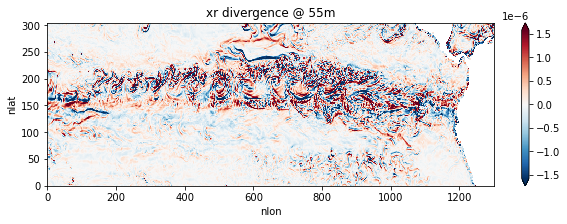

In [10]:
div_xr.isel(z_t=5, time=0).plot(robust=True, figsize=(10, 3))
plt.title("xr divergence @ {:d}m".format(int(div_xr.z_t.isel(z_t=5).values / 100)));

#### Minimal xgcm version

Instead of using xarray's {py:meth}`~xarray.DataArray.roll`, we can use xgcm's {py:meth}`~xgcm.Grid.diff` and {py:meth}`~xgcm.Grid.interp`:

In [11]:
# using xgcm
def div_4pt_xgcm(U, V):  # Basic stencil operator for B-grid divergence
    """
    POP stencil operator for divergence
    using xgcm
    """
    U_at_lat_t = grid.interp(U, axis="Y", boundary="extend")  # array - array.roll becomes interp
    # -> this incoorporates the * 0.5
    dUdx = grid.diff(U_at_lat_t, axis="X", boundary="extend")  # - becomes diff
    V_at_lon_t = grid.interp(V, axis="X", boundary="extend")
    dVdy = grid.diff(V_at_lon_t, axis="Y", boundary="extend")
    div_4pt = dUdx + dVdy
    return div_4pt


def divh_xgcm(U, V, ds_grid):  # Divergence of horizontal velocity. Result on T-grid
    """
    calulate divergence with xgcm
    """
    changed_U = U * ds_grid.DYU * ds_grid.DZU
    changed_V = V * ds_grid.DXU * ds_grid.DZU
    divh = div_4pt_xgcm(changed_U, changed_V) / (ds_grid.TAREA * ds_grid.DZT)
    return divh

In [12]:
div_xgcm = divh_xgcm(ds_ren.UVEL, ds_ren.VVEL, ds_ren)
div_xgcm

<xarray.DataArray (time: 1, z_t: 62, nlat_t: 305, nlon_t: 1301)>
array([[[[ 0.00000000e+00, -1.22930843e-06, -3.79666626e-08, ...,
                      nan,             nan,             nan],
         [ 1.29710470e-06, -1.80508841e-08,  8.54803433e-08, ...,
                      nan,             nan,             nan],
         [ 4.90406732e-07,  4.01141917e-08,  1.07027005e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.55323600e-07, -1.44758122e-08, -3.50509592e-09, ...,
          -1.28452313e-06, -1.62644312e-06, -1.83187388e-06],
         [ 1.10498548e-07, -6.68358532e-09, -5.60290977e-08, ...,
          -5.00422545e-07, -3.13788872e-07, -1.78077049e-07],
         [ 1.59686076e-07,  4.21211314e-09, -7.58155615e-08, ...,
           1.14357903e-06,  1.42170407e-06,  1.61619525e-06]],

        [[ 0.00000000e+00, -1.14137591e-06,  3.27276755e-08, ...,
                      nan,             nan,             nan],
         [ 1.33188653e-06,  1.08072630e-07,  2.01164913e-07, ...,
                      nan,             nan,             nan],
         [ 5.30723976e-07,  1.64829881e-07,  2.12093400e-07, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) object 0036-12-07 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 301.5 302.5 303.5 304.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 1.298e+03 1.3e+03 1.3e+03
    TLONG    (nlat_t, nlon_t) float64 159.9 160.0 160.1 ... 289.8 289.9 290.0
    TLAT     (nlat_t, nlon_t) float64 -15.07 -15.07 -15.07 ... 14.98 14.98 14.98

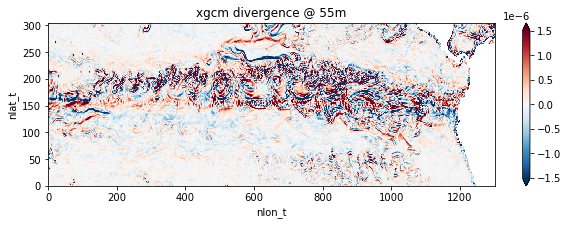

In [13]:
div_xgcm.isel(z_t=5, time=0).plot(robust=True, figsize=(10, 3))
plt.title("xgcm divergence @ {:d}m".format(int(div_xgcm.z_t.isel(z_t=5).values / 100)));

This is the same except for boundary points because the pure xarray version assumes that the boundaries are periodic

In [14]:
xr.testing.assert_equal(
    (
        div_xgcm.rename(
            {"nlon_t": "nlon", "nlat_t": "nlat"}
        )  # rename dimensions back to nlon, nlat
        .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
    (
        div_xr.assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
)

#### xgcm with metrics

If we create an ``xgcm.Grid`` object with the ``metrics`` term specified, the code can be substantially simplified.

For the metric capabilities we will use later on we need to define metrics for pop (this could be moved to ``pop_tools`` for convenience so that ``grid`` is always created with ``metrics`` information). 

``metrics`` is a dictionary that maps axes names (one of ``X, Y, Z``) to distances along that axis

In [15]:
# pop_tools should handle this bit in the future
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}

In [16]:
# xgcm metrics
gridm, xdsm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)

 Note that the code below does not explicitly use ``DZT`` or ``DZU``.

In [17]:
def div_stencil(U, V, grid):  # Basic stencil operator for B-grid divergence
    """
    stencil operator for divergence
    using xgcm.metrics on pop
    """
    U = grid.interp(U, axis="Y", boundary="extend")
    V = grid.interp(V, axis="X", boundary="extend")
    dUdx = grid.diff(U, axis="X", boundary="extend")
    dVdy = grid.diff(V, axis="Y", boundary="extend")
    div_4pt = dUdx + dVdy
    return div_4pt


def x_divh(U, V, grid, boundary=None):
    """
    horizontal divergence
    with xgcm.get_metrics
    """
    dy = grid.get_metric(U, "Y")
    dx = grid.get_metric(V, "X")
    dz = grid.get_metric(U, "Z")
    UT = U * dy * dz
    VT = V * dx * dz
    div = div_stencil(UT, VT, grid)
    volume = grid.get_metric(div, "XYZ")
    div = div / volume

    return div


div_xgcm_m = x_divh(xdsm.UVEL, xdsm.VVEL, gridm)
div_xgcm_m

<xarray.DataArray (time: 1, z_t: 62, nlat_t: 305, nlon_t: 1301)>
array([[[[ 0.00000000e+00, -1.22930843e-06, -3.79666626e-08, ...,
                      nan,             nan,             nan],
         [ 1.29710470e-06, -1.80508841e-08,  8.54803433e-08, ...,
                      nan,             nan,             nan],
         [ 4.90406732e-07,  4.01141917e-08,  1.07027005e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.55323600e-07, -1.44758122e-08, -3.50509592e-09, ...,
          -1.28452313e-06, -1.62644312e-06, -1.83187388e-06],
         [ 1.10498548e-07, -6.68358532e-09, -5.60290977e-08, ...,
          -5.00422545e-07, -3.13788872e-07, -1.78077049e-07],
         [ 1.59686076e-07,  4.21211314e-09, -7.58155615e-08, ...,
           1.14357903e-06,  1.42170407e-06,  1.61619525e-06]],

        [[ 0.00000000e+00, -1.14137591e-06,  3.27276755e-08, ...,
                      nan,             nan,             nan],
         [ 1.33188653e-06,  1.08072630e-07,  2.01164913e-07, ...,
                      nan,             nan,             nan],
         [ 5.30723976e-07,  1.64829881e-07,  2.12093400e-07, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) object 0036-12-07 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 301.5 302.5 303.5 304.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 1.298e+03 1.3e+03 1.3e+03

This works as follows: ``grid.get_metric(U, "Y")`` tells ``xgcm`` to find a ``DY`` variable that is at U-points. 

``xgcm`` checks ``DYU`` and ``DYT`` (both specified as Y-distances in ``metrics``) and chooses ``DYU`` because ``DYU.dims = (nlat_u, nlon_u)`` matches ``U.dims = ("time", "z_t", "nlat_u", "nlon_u")``

In [18]:
print(xdsm.DYU.dims)
print(xdsm.UVEL.dims)

('nlat_u', 'nlon_u')
('time', 'z_t', 'nlat_u', 'nlon_u')


In [19]:
xr.testing.assert_equal(
    gridm.get_metric(xdsm.UVEL, "Y"),
    xdsm.DYU.reset_coords(drop=True),
)

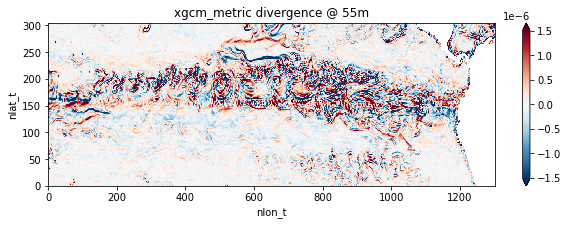

In [20]:
div_xgcm_m.isel(z_t=5, time=0).plot(robust=True, figsize=(10, 3))
plt.title("xgcm_metric divergence @ {:d}m".format(int(div_xgcm_m.z_t.isel(z_t=5).values / 100)));

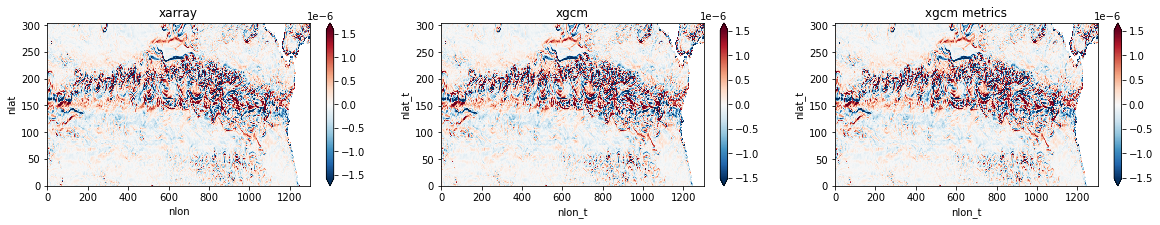

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
div_xr.isel(z_t=5, time=0).plot(ax=ax[0], robust=True)
ax[0].set_title("xarray")
div_xgcm.isel(z_t=5, time=0).plot(ax=ax[1], robust=True)
ax[1].set_title("xgcm")
div_xgcm_m.isel(z_t=5, time=0).plot(ax=ax[2], robust=True)
ax[2].set_title("xgcm metrics");

The two xgcm versions agree in the treatment of boundaries, whereas xarray assumes periodic boundaries so that the boundary values differ (the rest are the same):

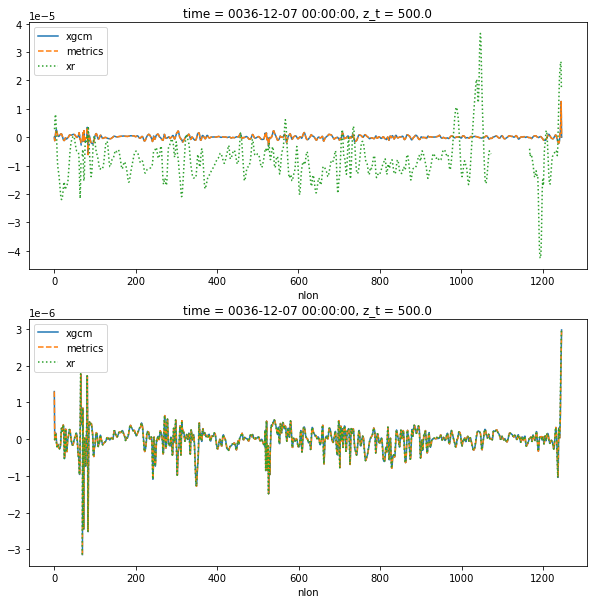

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
div_xgcm.isel(nlat_t=0, z_t=0).plot(label="xgcm", ax=ax[0])
div_xgcm_m.isel(nlat_t=0, z_t=0).plot(ls="--", label="metrics", ax=ax[0])
div_xr.isel(nlat=0, z_t=0).plot(label="xr", ax=ax[0], ls=':')
ax[0].legend()

div_xgcm.isel(nlat_t=1, z_t=0).plot(label="xgcm", ax=ax[1])
div_xgcm_m.isel(nlat_t=1, z_t=0).plot(ls="--", label="metrics", ax=ax[1])
div_xr.isel(nlat=1, z_t=0).plot(label="xr", ax=ax[1], ls=':')
ax[1].legend();

In [23]:
# the two xgcm versions are the same
xr.testing.assert_equal(div_xgcm.drop(["TLONG", "TLAT"]), div_xgcm_m)

### 2) Curl

In [24]:
# define different functions for curl
def z_curl_xr(U, V, ds_grid):
    """
    xr based
    """
    vdy = 0.5 * V * ds.DYU
    udx = -0.5 * U * ds.DXU
    zcurl = div_4pt_xr(vdy, udx) / ds.TAREA
    return zcurl


def z_curl_xgcm(U, V, ds_grid):
    """
    xgcm based
    """
    WORKX = V * ds_grid.DYU
    WORKY = -U * ds_grid.DXU
    zcurl = div_4pt_xgcm(WORKX, WORKY) / ds_grid.TAREA
    return zcurl


def x_curlz(U, V, grid):
    """
    xgcm based using metrics
    """
    Udx = U * grid.get_metric(U, "X")
    Vdy = V * grid.get_metric(V, "Y")
    der = div_stencil(Vdy, -Udx, grid)
    area = grid.get_metric(der, "XY")
    curlz = der / area
    return curlz

In [25]:
xr_zcurl = z_curl_xr(ds.UVEL, ds.VVEL, ds)
xgcm_zcurl = z_curl_xgcm(ds_ren.UVEL, ds_ren.VVEL, ds_ren)
xgcm_m_zcurl = x_curlz(ds_ren.UVEL, ds_ren.VVEL, gridm)

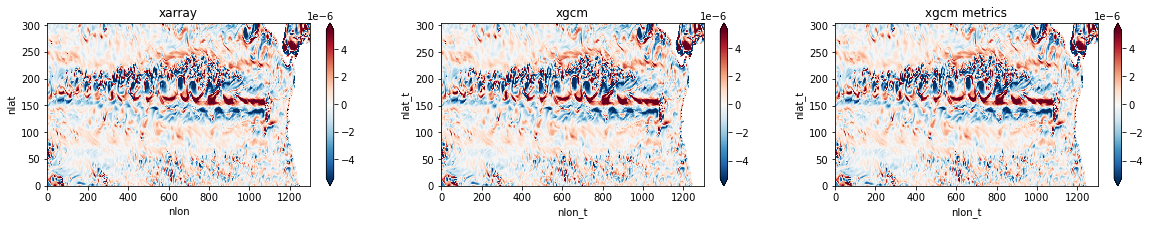

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
xr_zcurl.isel(z_t=5, time=0).plot(ax=ax[0], robust=True)
ax[0].set_title("xarray")
xgcm_zcurl.isel(z_t=5, time=0).plot(ax=ax[1], robust=True)
ax[1].set_title("xgcm")
xgcm_m_zcurl.isel(z_t=5, time=0).plot(ax=ax[2], robust=True)
ax[2].set_title("xgcm metrics");

In [27]:
# test xgcm versions:
xr.testing.assert_equal(xgcm_zcurl.drop(["TLONG", "TLAT"]), xgcm_m_zcurl)

In [28]:
# test xarray vs xgcm version:
xr.testing.assert_equal(
    (
        xr_zcurl.drop(["TLONG", "TLAT", "ULONG", "ULAT"])
        .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
    (
        xgcm_zcurl.rename({"nlon_t": "nlon", "nlat_t": "nlat"})
        .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
)

### 3) Gradient

In [29]:
# define different functions
# xarray
def grad_4pt_xr(F):
    """
    gradient stencil using xarray
    """
    WORK2 = F.roll(nlat=-1, roll_coords=False)  # F[i,j+1]
    WORK1 = WORK2.roll(nlon=-1, roll_coords=False) - F  # F[i+1,j+1] - F[i,j]
    WORK2 = WORK2 - F.roll(nlon=-1, roll_coords=False)  # F[i,j+1] - F[i+1,j]
    GX = WORK1 - WORK2
    GY = WORK1 + WORK2
    return GX, GY


def gradh_xr(F, DX, DY):
    """
    gradient calculation
    """
    GX, GY = grad_4pt_xr(F)
    GX = 0.5 * GX / DX
    GY = 0.5 * GY / DY
    return GX, GY


# xgcm
def grad_4pt_xgcm(F):  # Basic stencil operator for B-grid gradient (e.g. for pressure)
    """
    gradient stencil with xgcm
    """
    F_at_lat_u = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    dFdx = grid.diff(F_at_lat_u, axis="X", boundary="extend")
    F_at_lon_u = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdy = grid.diff(F_at_lon_u, axis="Y", boundary="extend")
    return dFdx, dFdy


def gradh_xgcm(F, ds_grid):  # Gradient of scalar. Result on U-grid
    """
    gradient of scalar
    """
    GX, GY = grad_4pt_xgcm(F)
    GX = GX / ds_grid.DXU
    GY = GY / ds_grid.DYU
    return GX, GY


# xgcm_metrics -> this becomes really easy!
def x_gradh(F, grid):
    """
    gradient of scalar xgcm_metrics
    for pop
    """
    F_yi = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    F_xi = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdx = grid.derivative(F_yi, axis="X", boundary="extend")
    dFdy = grid.derivative(F_xi, axis="Y", boundary="extend")
    return dFdx, dFdy

In [30]:
# test different versions
GX_x, GY_x = gradh_xr(ds.TEMP, ds.DXT, ds.DYU)  # xarray version
GX_xgcm, GY_xgcm = gradh_xgcm(ds_ren.TEMP, ds_ren)  # xgcm version
GX_xgcm_m, GY_xgcm_m = x_gradh(ds_ren.TEMP, gridm)  # xgcm metrics version

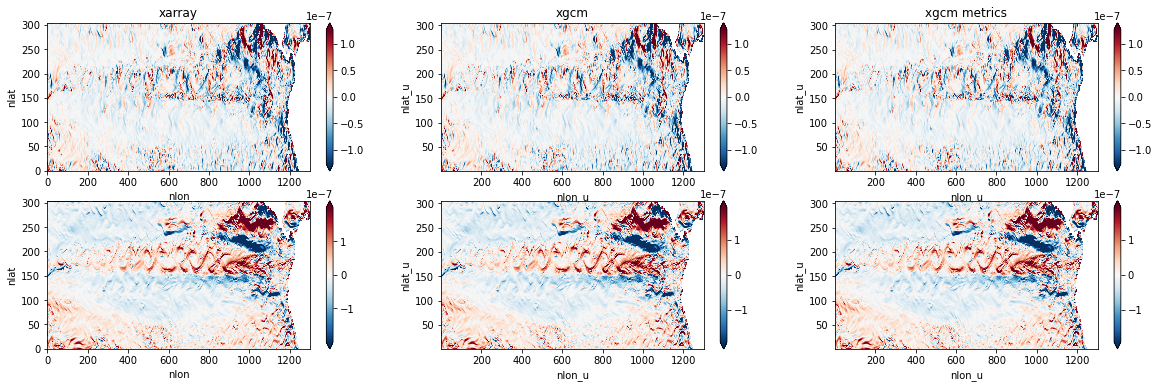

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(20, 6))
GX_x.isel(z_t=5, time=0).plot(ax=ax[0, 0], robust=True)
ax[0, 0].set_title("xarray")
GX_xgcm.isel(z_t=5, time=0).plot(ax=ax[0, 1], robust=True)
ax[0, 1].set_title("xgcm")
GX_xgcm_m.isel(z_t=5, time=0).plot(ax=ax[0, 2], robust=True)
ax[0, 2].set_title("xgcm metrics")

GY_x.isel(z_t=5, time=0).plot(ax=ax[1, 0], robust=True)
ax[1, 0].set_title("")
GY_xgcm.isel(z_t=5, time=0).plot(ax=ax[1, 1], robust=True)
ax[1, 1].set_title("")
GY_xgcm_m.isel(z_t=5, time=0).plot(ax=ax[1, 2], robust=True)
ax[1, 2].set_title("");

In [32]:
# testing xgcm version:
xr.testing.assert_equal(GX_xgcm_m, GX_xgcm.drop(["ULONG", "ULAT"]))

In [33]:
# testing xarray version xgcm version:
xr.testing.assert_allclose(
    (
        GX_x.drop(["TLONG", "TLAT", "ULONG", "ULAT"])
        .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
    (
        GX_xgcm_m.rename({"nlon_u": "nlon", "nlat_u": "nlat"})
        .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
)

In [34]:
%load_ext watermark
%watermark -d -iv -m -g

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 824cc23a5f921ee3ecf3fe3947cb435dd532e451

xarray    : 0.17.0
numpy     : 1.20.1
xgcm      : 0.5.1
matplotlib: 3.3.4
pop_tools : 2020.12.15.post10+dirty

